_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 1

## Introduction

In this coding lab you get to implement a pipeline for spike detection and feature extraction, as presented in the lecture:
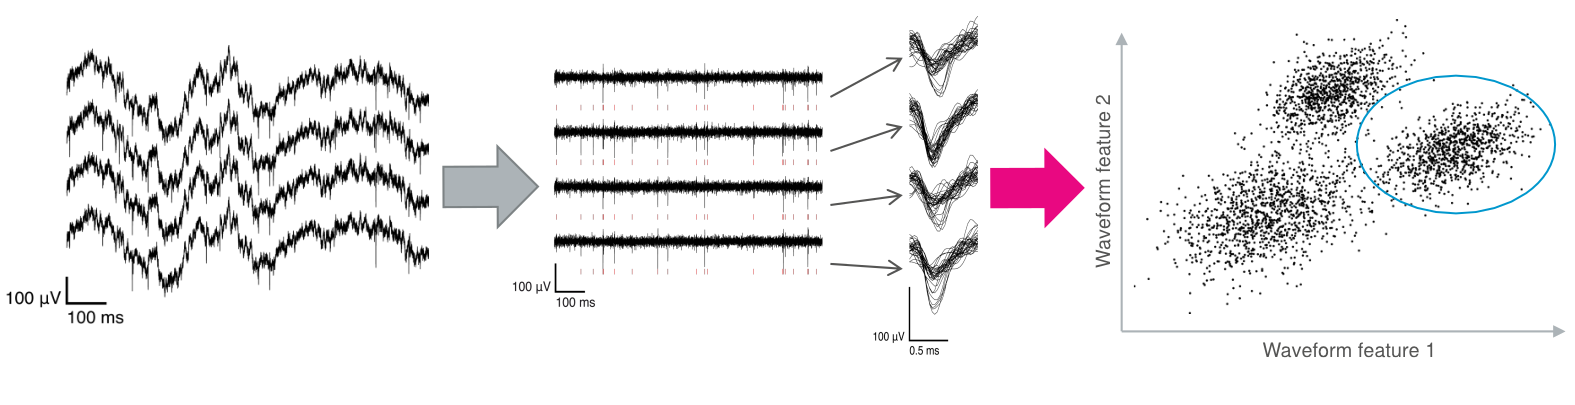

This will later be used for spike sorting (identifying which spike / waveform in the signal was caused by which neuron).

The data used in this notebook was recorded at 30kHz with a tetrode and thus contains the voltage traces of the 4 channels in μV.

_(for more information on the data acquisition, you can have a look at [Ecker et al 2014](https://doi.org/10.1016/j.neuron.2014.02.006), in particular the supplementary material. A similar pipeline is also used in [Ecker et al 2010](https://doi.org/10.1126/science.1179867). Note however that we only use a small portion of the data in this notebook and most of the experiment setup is not relevant here!)_

## Setup
- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-04-21 17:23:49CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

pandas    : 2.2.3
numpy     : 2.2.4
matplotlib: 3.10.1
sklearn   : 1.6.1
scipy     : 1.15.2

Watermark: 2.5.0



In [31]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [32]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [33]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>.

Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 3 pts*


In [34]:
## Current Best Practice
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # -----------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1pt)
    # -----------------------------------------------------------------

    b, a = signal.butter(
        N=order, Wn=[low, high], fs=fs, btype="bandpass"  # butterworth bandpass filter
    )
    y = signal.filtfilt(b, a, x, axis=0)  # apply zero-phase filtering

    return pd.DataFrame(y, columns=x.columns, index=x.index)

In [35]:
order = 5
xf = filter_signal(x, fs, 500, 4000, order=order)

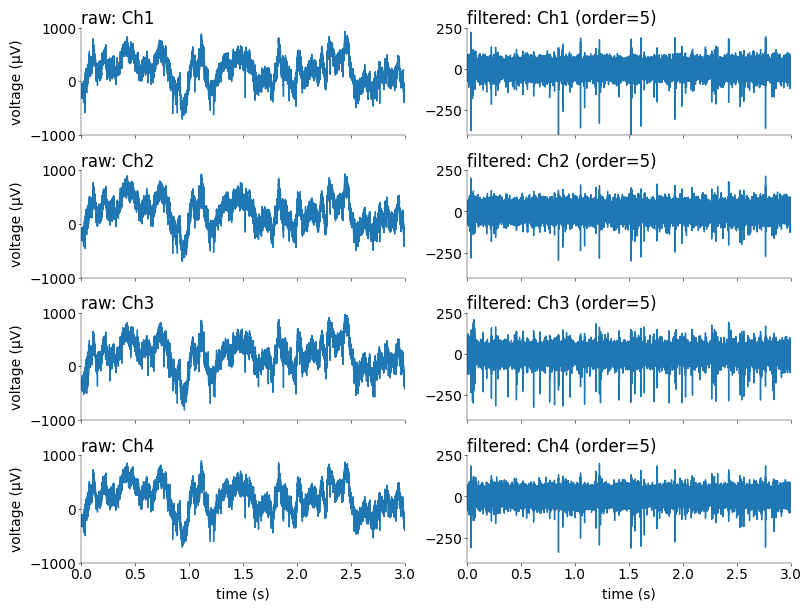

In [36]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------

T = 100000
t = np.arange(0, T) * dt

for i, (raw, filtered) in enumerate(mosaic):

    ch = f"Ch{i+1}"  # generate the channel names Ch1, Ch2, Ch3, Ch4
    ax[raw].plot(t[:T], x[ch].values[:T])  # plot raw data in time range
    ax[filtered].plot(t[:T], xf[ch].values[:T])  # plot filtered data in time range

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    # Add labels and title
    ax[raw].set_ylabel("voltage (μV)")
    ax[raw].set_title(raw, loc="left")
    ax[filtered].set_title(
        f"{filtered} (order={order})", loc="left"
    )  # 👈 this line adds the order info
    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

### Questions
1) Explain your implementation: Which filter and parameters did you choose and why?

filter: butterworth bandpass filter

parameters: order of the butterworth filter = TODO. With a lower order, there would be more unwanted noise left in the signal after filtering. However, an even higher order would have been too expensive.

2) Which parameters of the function can be adjusted, which are determined by the experiment setup? What is the effect of the adjustable parameters?

Predetermined:
* sampling frequency (30kHz)
* number of recording channels (tetrode, i.e. 4 channels)

Adjustable:
* Passband of the Butterworth filter (i.e. lower and upper limit) -> determines the range of frequencies that the bandpass filter "allows" to pass wothout attenuation
* Order of the Butterworth filter -> Basically: the higher the order the better the filter is at blocking the frequencies. BUt higher order filters are more complex and computationally expensive and tend to introduce phase shifts, i.e. different frequency components of a signal get delayed by different amounts of time as they pass through the filter.
3) How does the filtered signal look compared to the original? Why is this helpful as preprocessing in our spike detection pipeline?

High and low frequencies are filtered out, i.e. only medium frequencies are left. This helps cancel out any noise that is not interesting to us and leaves us with clearer spikes.

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()```.

Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes, also **plot the threshold**.

*Grading: 4 pts*

In [37]:
def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # --------------------------------------------------------------
    # compute the robust s.d. and calculate the threshold (0.5 pts)
    # --------------------------------------------------------------

    sigma = np.median(np.abs(x - np.median(x)))  # outlier robust estimation of the sd
    thrd = -N * sigma  # compute threshold

    # --------------------------
    # find all spikes (1.5 pts)
    # --------------------------

    s = []
    t = []

    for ch in range(x.shape[1]):  # iterate through channels
        peaks, properties = signal.find_peaks(
            x.iloc[:, ch], height=thrd, distance=lockout
        )  # find spikes

        s.append(peaks)
        t.append(properties["peak_heights"])

    return s, t, thrd

In [38]:
spike_loc, spike_t, thrd = detect_spikes(xf, fs)

ValueError: Input could not be cast to an at-least-1D NumPy array

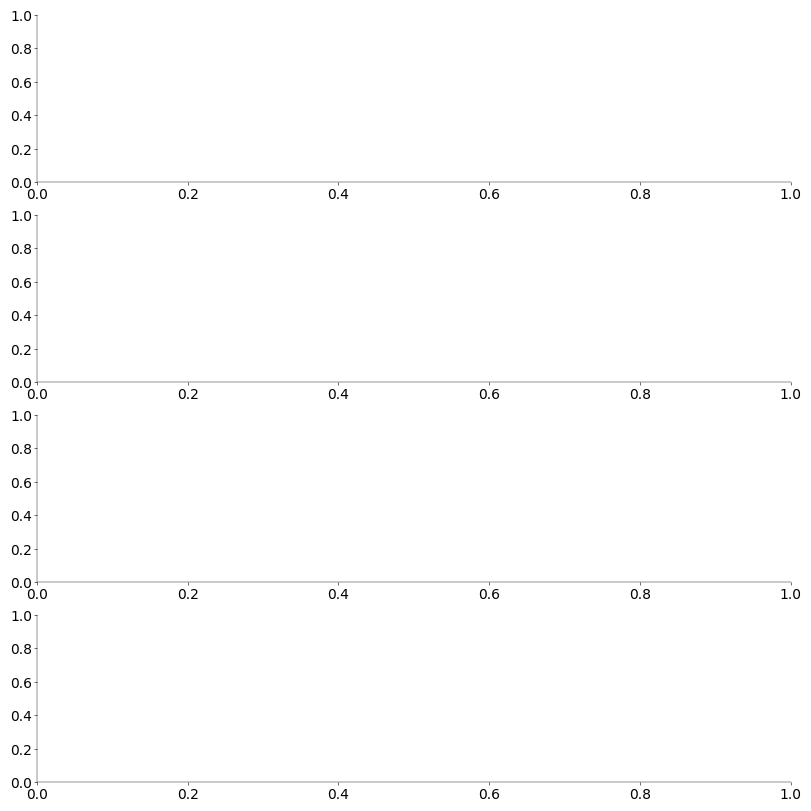

In [39]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------
# plot signal, threshold and detected spikes and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------

for i, col in enumerate(cols):

    # TODO: spike_loc, spike_t, thrd  # plot location of spikes, time of spikes, threshold
    plt.plot(spike_loc)

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage (μV)")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

### Questions

1) Are the detected time points well aligned with prominent extrema in the signal? Also compare your detections across channels.

_YOUR ANSWER HERE_

2) Take one feature of the spikes and explain how that can help us identifying the source neuron of a spike (only based on visual examination of the plot).

_YOUR ANSWER HERE_

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```.

Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.
Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 3 pts*

In [ ]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # -------------------------------
    # extract spike waveforms (1 pt)
    # -------------------------------

    length_window = 30  # define the length of the waveform window
    half_length = length_window // 2  # samples before and after the spike

    # filter out spikes that are too close to the edges
    edge_spikes = np.where((s < half_length) | (s > x.shape[0] - half_length))[0]  # find edge spikes
    s = np.delete(s, edge_spikes)  # remove edge spikes

    waveforms = np.zeros(
        (len(s), length_window, x.shape[1])
    )  # initialize the waveforms array

    # loop through the spikes and populate the waveforms array
    for i, spike in enumerate(s):
        # extract the waveform around the spike
        waveforms[i] = x[spike - half_length : spike + half_length, :]

    return waveforms

Plot first 100 spike waveforms

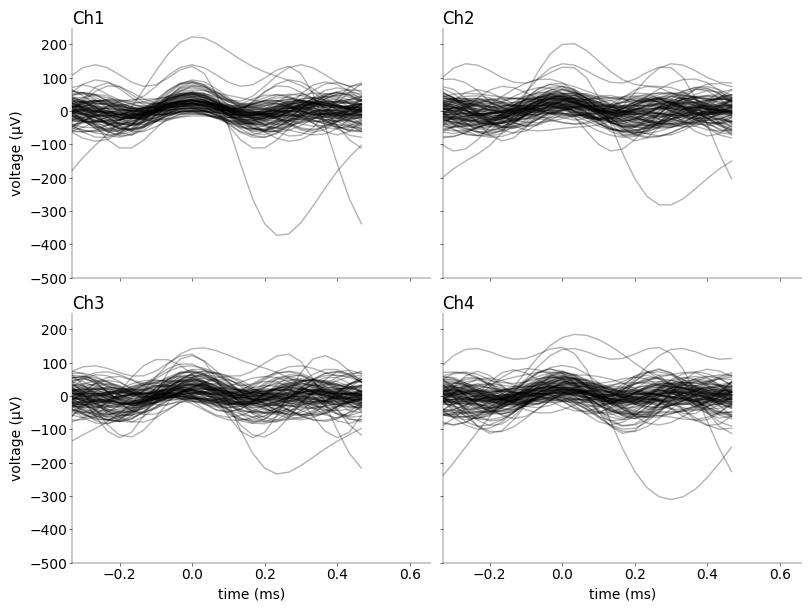

In [ ]:
# ---------------------------------------------------------------------
# plot first and largest 100 spikes and answer the questions (1+1 pts)
# ---------------------------------------------------------------------

# first 100 spikes
# Flatten and concatenate spike indices from all channels
spike_samples = np.concatenate(spike_loc)

# Optional: sort and remove duplicates
# spike_samples = np.unique(spike_samples)

waveforms = extract_waveforms(xf.values, spike_samples)
first_100 = waveforms[:100]

length_window = waveforms.shape[1]
t = (np.arange(length_window) - length_window // 2) * (1000 / fs)  # ms

mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

# plot the first 100 waveforms on each channel
for spike_idx in range(100):
    for ch_idx, col in enumerate(cols):
        ax[col].plot(t, first_100[spike_idx, :, ch_idx], color="black", alpha=0.3)

Plot largest 100 spike waveforms

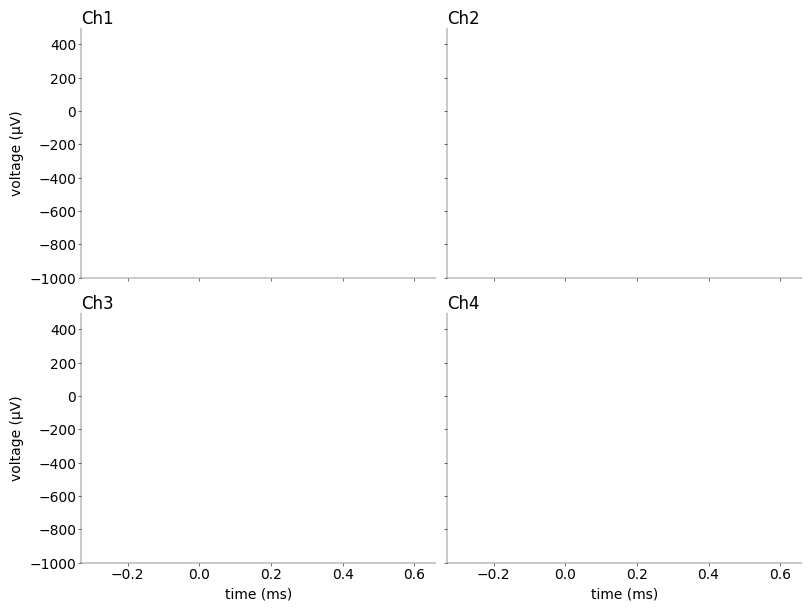

In [ ]:
# largest 100 spikes

fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

### Questions

1) Describe the shape of the spikes.

_YOUR ANSWER HERE_

1) Do the waveforms tend to be similar? If spikes have a similar waveform, what could that mean - and what does it mean if the waveforms look different?

_YOUR ANSWER HERE_

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs. Also return the obtained parameters of the PCA

For one channel, plot the mean and the first three principal axes as calculated by the PCA in the feature space. Interprete them in light of the plots in the previous tasks.

For all pairwise combinations of channels, plot the resulting features of the 1st PCs as scatter plots against each other. Do you see clusters visually?

*Grading: 6 pts*

## PCA
### Questions (1 pt)
1) If we input the data from each channel separately to a PCA, what are the feature dimension of the input?

_YOUR ANSWER HERE_

2) Therefore, what do the Principal Axes the PCA computes represent?

_YOUR ANSWER HERE_

3) Does it make sense to apply preprocessing steps, such as normalization? Have a look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). What is applied by default?

_YOUR ANSWER HERE_

In [ ]:
"""Solution"""


def extract_features(w: np.ndarray) -> np.ndarray:
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)
        the transformed data
    means: np.ndarray, (n_channels, length_window)
        means per channel
    principal_components: np.ndarray, (n_channels, 3, length_window)
        the 'principal axes' obtained by the pca


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # ----------------------------------------------
    # obtain first 3 principle components (1.5 pts)
    # ----------------------------------------------

    # -----------------------------------------------------------------------------------------------------
    # Print the fraction of variance explained by the three components combined for each channel (0.5 pts)
    # -----------------------------------------------------------------------------------------------------

    pass

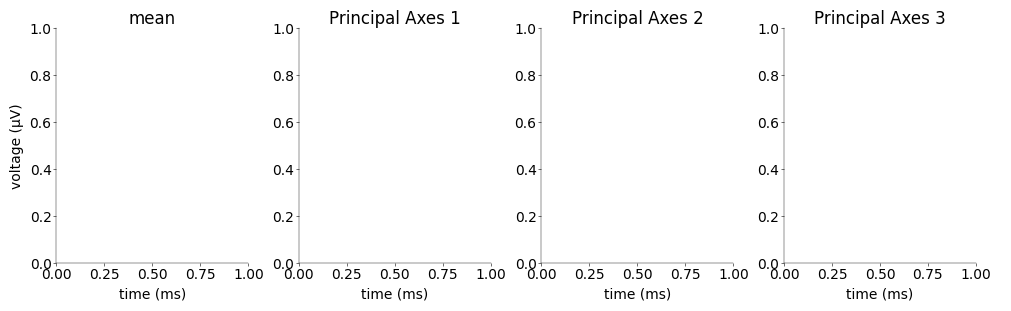

In [ ]:
"""Solution"""

# ------------------------------------------------------------------------------------------------------------------
# Plot the mean of each channel and the three principal axes obtained by the PCA and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------------------------------------

mosaic = [
    ["mean", "Principal Axes 1", "Principal Axes 2", "Principal Axes 3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(10, 3), layout="constrained", dpi=100
)

for channel in range(4):
    for i, mo in enumerate(np.ravel(mosaic)):

        ax[mo].set_xlabel("time (ms)")
        ax[mo].set_title(mo)

ax[mosaic[0][0]].set_ylabel("voltage (μV)")
ax[mosaic[0][-1]].legend(
    ["Channel " + str(i) for i in range(4)],
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
)
plt.show()

### Questions

1) Compare the plot to the plots of the other tasks. What do you observe?

_YOUR ANSWER HERE_

2) What does the mean look like? Does this match your expectations?

_YOUR ANSWER HERE_

3) Explain what it means if a spike has a high value in the first dimension. What is the effect of the other dimensions?

_YOUR ANSWER HERE_

Text(0.5, 0.98, 'Pairwise 1st PCs')

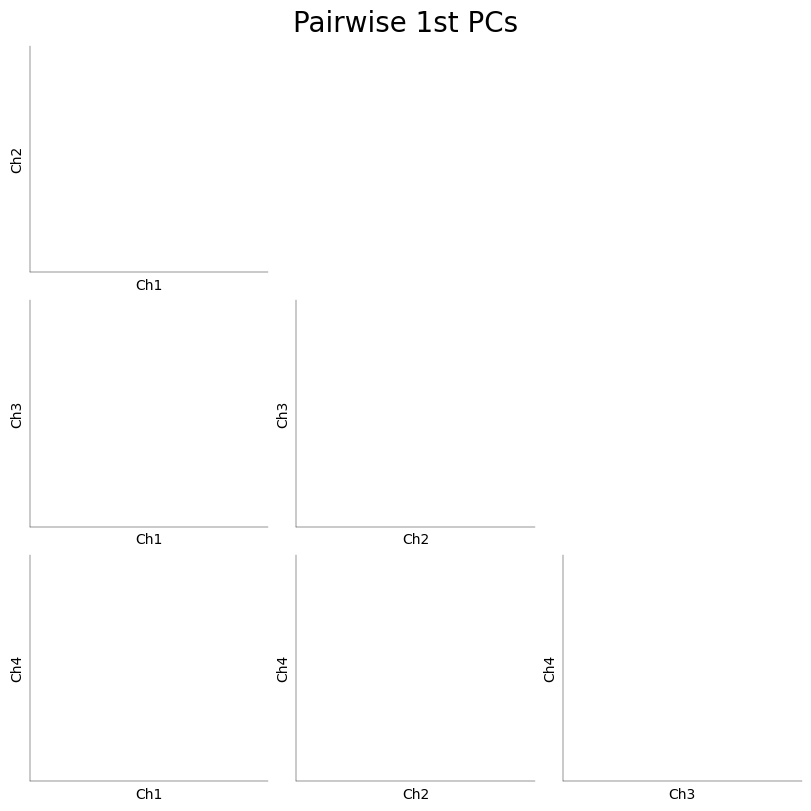

In [ ]:
"""Solution"""

# ----------------------------------------------------------------------------------------------------------
# Create a scatterplot of the projections of the spikes for all pairwise combinations of the 1st PCs (1 pt)
# ----------------------------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-1500, 1500))
    ax[mo].set_ylim((-1500, 1500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [ ]:
# save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)